# Rupture distances (Rrup, Rx, Rjb) in openquake.hazardlib

In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

from openquake.hazardlib.geo import (
    Point, Line, PlanarSurface, MultiSurface, SimpleFaultSurface,
    ComplexFaultSurface, RectangularMesh
)

import numpy
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap

In [4]:
def get_grid_and_map_proj(surf, buf=0.3, delta=0.001):
    """
    Return grid of nodes and map projection specific to surface
    """
    min_lon, max_lon, max_lat, min_lat = surf.get_bounding_box()
    
    min_lon -= buf
    max_lon += buf
    min_lat -= buf
    max_lat += buf

    lons = numpy.arange(min_lon, max_lon + delta, delta)
    lats = numpy.arange(min_lat, max_lat + delta, delta)
    lons, lats = numpy.meshgrid(lons, lats)
    mesh = RectangularMesh(lons=lons, lats=lats, depths=None)
    
    m = Basemap(projection='merc', llcrnrlat=numpy.min(lats), urcrnrlat=numpy.max(lats),
                llcrnrlon=numpy.min(lons), urcrnrlon=numpy.max(lons), resolution='l')
    
    return mesh, m

# Distances to single Planar Surface

In [5]:
# define planar surface
surf= PlanarSurface(
    mesh_spacing=2., strike=3., dip=40.,
    top_left = Point(depth=2.0, latitude=36.539, longitude=137.874),
    top_right = Point(depth=2.0, latitude=36.7680117889, longitude=137.888982562),
    bottom_left = Point(depth=14.8557521937, latitude=36.5316665297, longitude=138.045238973),
    bottom_right = Point(depth=14.8557521937, latitude=36.7606772927, longitude=138.060731463)
)

# get grid of points for which to calculate distances and associated map projection
mesh, m = get_grid_and_map_proj(surf)
x, y = m(mesh.lons, mesh.lats)

In [6]:
print mesh.lons.shape
print mesh.lats.shape

(838, 788)
(838, 788)


In [7]:
# extract coordinates of rupture surface boundary
boundary_lons = [
    surf.top_left.longitude, surf.top_right.longitude,
    surf.bottom_right.longitude, surf.bottom_left.longitude, surf.top_left.longitude
]
boundary_lats = [
    surf.top_left.latitude, surf.top_right.latitude,
    surf.bottom_right.latitude, surf.bottom_left.latitude, surf.top_left.latitude
]
boundary_x, boundary_y = m(boundary_lons, boundary_lats)

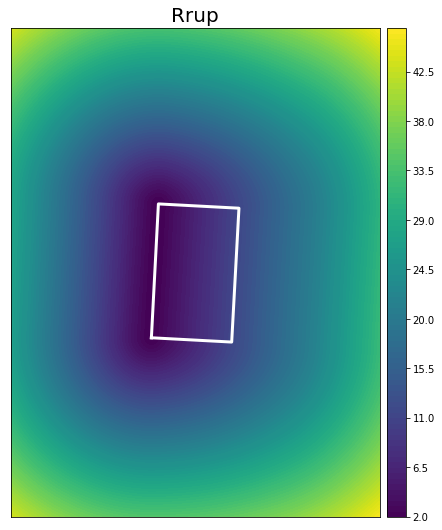

In [8]:
# compute and plot Rrup
r_rup = surf.get_min_distance(mesh)

fig = pyplot.figure(figsize=(9, 9))
m.plot(boundary_x, boundary_y, linewidth=3, color='white')
m.contourf(x, y, r_rup, 100)
#m.drawparallels(numpy.arange(numpy.min(mesh.lats), numpy.max(mesh.lats), 0.1), labels=[True, False, False, True])
#m.drawmeridians(numpy.arange(numpy.min(mesh.lons), numpy.max(mesh.lons), 0.1), labels=[True, False, False, True])
m.colorbar()
pyplot.title('Rrup', fontsize=20)

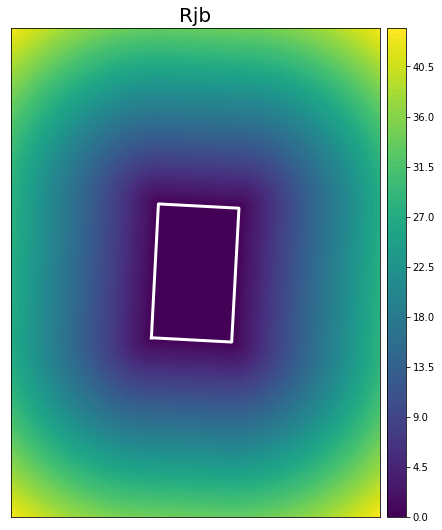

In [9]:
# compute and plot Rjb
r_jb = surf.get_joyner_boore_distance(mesh)

fig = pyplot.figure(figsize=(9, 9))
m.plot(boundary_x, boundary_y, linewidth=3, color='white')
m.contourf(x, y, r_jb, 100)
# m.drawparallels(numpy.arange(numpy.min(mesh.lats), numpy.max(mesh.lats), 0.1), labels=[True, False, False, True])
# m.drawmeridians(numpy.arange(numpy.min(mesh.lons), numpy.max(mesh.lons), 0.1), labels=[True, False, False, True])
m.colorbar()
pyplot.title('Rjb', fontsize=20)

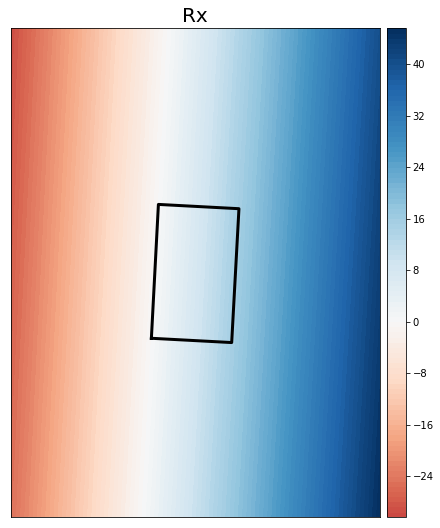

In [10]:
# compute and plot Rx
r_x = surf.get_rx_distance(mesh)

fig = pyplot.figure(figsize=(9,9))
m.plot(boundary_x, boundary_y, linewidth=3, color='black')
m.contourf(x, y, r_x, 100, cmap='RdBu')
# m.drawparallels(numpy.arange(numpy.min(mesh.lats), numpy.max(mesh.lats), 0.1), labels=[True, False, False, True])
# m.drawmeridians(numpy.arange(numpy.min(mesh.lons), numpy.max(mesh.lons), 0.1), labels=[True, False, False, True])
m.colorbar()
pyplot.clim((- numpy.max(r_x), numpy.max(r_x)))
pyplot.title('Rx', fontsize=20)

# Distances to Simple Fault Surface

In [11]:
# create Simple Fault Surface
surf = SimpleFaultSurface.from_fault_data(
    fault_trace=Line([Point(9.21602706445, 45.1555287905), Point(9.25645636929, 45.1877167851),
                  Point(9.29688464252, 45.2199047798), Point(9.35715705075, 45.2398017764),
                  Point(9.42902686305, 45.2401237764), Point(9.47246500782, 45.2381597767),
                  Point(9.51590215304, 45.236194777), Point(9.56736930079, 45.2307927779),
                  Point(9.61883544823, 45.2253897788), Point(9.67030259419, 45.2199877797),
                  Point(9.72270625188, 45.2033947825), Point(9.77510990175, 45.1868007853),
                  Point(9.83238881096, 45.1680237884), Point(9.88966771001, 45.1492457915),
                  Point(9.94694559775, 45.1304687947), Point(10.0042244753, 45.1116907978)]),
    upper_seismogenic_depth=2.,
    lower_seismogenic_depth=7.,
    dip=30.,
    mesh_spacing=4.
)

# get grid of points for which to calculate distances and associated map projection
mesh, m = get_grid_and_map_proj(surf, delta=0.002)
x, y = m(mesh.lons, mesh.lats)

In [12]:
mesh.lons.shape

(414, 698)

In [13]:
# extract coordinates of rupture surface boundary
rup_mesh = surf.get_mesh()
boundary_lons = numpy.concatenate(
    (rup_mesh.lons[0, :], rup_mesh.lons[1:, -1], rup_mesh.lons[-1,:-1][::-1], rup_mesh.lons[:-1, 0][::-1])
)
boundary_lats = numpy.concatenate(
    (rup_mesh.lats[0, :], rup_mesh.lats[1:, -1], rup_mesh.lats[-1,:-1][::-1], rup_mesh.lats[:-1, 0][::-1])
)
boundary_x, boundary_y = m(boundary_lons, boundary_lats)

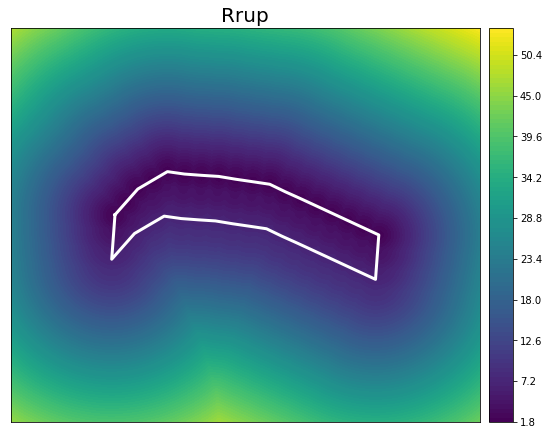

In [14]:
# compute and plot Rrup
r_rup = surf.get_min_distance(mesh)

fig = pyplot.figure(figsize=(9, 9))
m.plot(boundary_x, boundary_y, linewidth=3, color='white')
m.contourf(x, y, r_rup, 100)
# m.drawparallels(numpy.arange(numpy.min(mesh.lats), numpy.max(mesh.lats), 0.2), labels=[True, False, False, True])
# m.drawmeridians(numpy.arange(numpy.min(mesh.lons), numpy.max(mesh.lons), 0.2), labels=[True, False, False, True])
m.colorbar()
pyplot.title('Rrup', fontsize=20)

In [15]:
# compute and plot Rjb
r_jb = surf.get_joyner_boore_distance(mesh)

fig = pyplot.figure(figsize=(9, 9))
m.plot(boundary_x, boundary_y, linewidth=3, color='white')
m.contourf(x, y, r_jb, 100)
#m.drawparallels(numpy.arange(numpy.min(mesh.lats), numpy.max(mesh.lats), 0.2), labels=[True, False, False, True])
#m.drawmeridians(numpy.arange(numpy.min(mesh.lons), numpy.max(mesh.lons), 0.2), labels=[True, False, False, True])
m.colorbar()
pyplot.title('Rjb', fontsize=20)

ValueError: could not broadcast input array from shape (414,698) into shape (414)

# Distances to Complex Fault Surface

In [16]:
top_edge = Line([Point(144.069555556, 39.7059999996, 9.202), Point(143.987666642, 39.0726212093, 9.202),
                 Point(143.844804987, 38.4446225095, 9.202), Point(143.715121187, 37.8147879271, 9.202),
                 Point(143.452451355, 37.2149977193, 9.202), Point(143.086155668, 36.6503300815, 9.202),
                 Point(142.589773574, 36.1569466634, 9.202), Point(142.202909091, 35.606, 9.202)])

bottom_edge = Line([Point(142.0450625, 39.7059999997, 48.202), Point(141.970993342, 39.1530522533, 48.202),
                    Point(141.893707006, 38.6004781864, 48.202), Point(141.734990146, 38.0590949727, 48.202),
                    Point(141.52384879, 37.5292617122, 48.202), Point(141.2114751, 37.0322180634, 48.202),
                    Point(140.900140283, 36.5353773475, 48.202), Point(140.697696296, 36.006, 48.202)])

edges = [top_edge, bottom_edge]

surf = ComplexFaultSurface.from_fault_data(edges, mesh_spacing=10.)

# get grid of points for which to calculate distances and associated map projection
mesh, m = get_grid_and_map_proj(surf, delta=0.05)
x, y = m(mesh.lons, mesh.lats)

In [17]:
# extract coordinates of rupture surface boundary
rup_mesh = surf.get_mesh()
boundary_lons = numpy.concatenate(
    (rup_mesh.lons[0, :], rup_mesh.lons[1:, -1], rup_mesh.lons[-1,:-1][::-1], rup_mesh.lons[:-1, 0][::-1])
)
boundary_lats = numpy.concatenate(
    (rup_mesh.lats[0, :], rup_mesh.lats[1:, -1], rup_mesh.lats[-1,:-1][::-1], rup_mesh.lats[:-1, 0][::-1])
)
boundary_x, boundary_y = m(boundary_lons, boundary_lats)

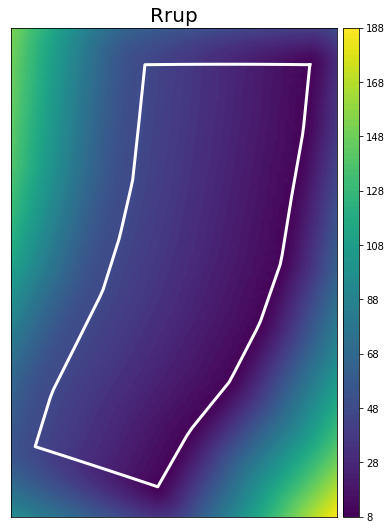

In [18]:
# compute and plot Rrup
r_rup = surf.get_min_distance(mesh)

fig = pyplot.figure(figsize=(9, 9))
m.plot(boundary_x, boundary_y, linewidth=3, color='white')
m.contourf(x, y, r_rup, 100)
# m.drawparallels(numpy.arange(numpy.min(mesh.lats), numpy.max(mesh.lats), 1.), labels=[True, False, False, True])
# m.drawmeridians(numpy.arange(numpy.min(mesh.lons), numpy.max(mesh.lons), 1.), labels=[True, False, False, True])
m.colorbar()
pyplot.title('Rrup', fontsize=20)

In [19]:
# compute and plot Rjb
r_jb = surf.get_joyner_boore_distance(mesh)

fig = pyplot.figure(figsize=(9, 9))
m.plot(boundary_x, boundary_y, linewidth=3, color='white')
m.contourf(x, y, r_jb, 100)
# m.drawparallels(numpy.arange(numpy.min(mesh.lats), numpy.max(mesh.lats), 1.), labels=[True, False, False, True])
# m.drawmeridians(numpy.arange(numpy.min(mesh.lons), numpy.max(mesh.lons), 1.), labels=[True, False, False, True])
m.colorbar()
pyplot.title('Rjb', fontsize=20)

ValueError: operands could not be broadcast together with shapes (846,) (81,) 

# Distances to Multi Surface

In [ ]:
# define Multi Surface as list of planar surfaces
p1 = PlanarSurface(
    mesh_spacing=2., strike=3., dip=40.,
    top_left = Point(depth=2.0, latitude=36.539, longitude=137.874),
    top_right = Point(depth=2.0, latitude=36.7680117889, longitude=137.888982562),
    bottom_left = Point(depth=14.8557521937, latitude=36.5316665297, longitude=138.045238973),
    bottom_right = Point(depth=14.8557521937, latitude=36.7606772927, longitude=138.060731463)
)
p2 = PlanarSurface(
    mesh_spacing=2., strike=344., dip=40.,
    top_left = Point(depth=2.0, latitude=36.2320586295, longitude=137.983095101),
    top_right = Point(depth=2.0, latitude=36.539, longitude=137.874),
    bottom_left = Point(depth=14.8557521937, latitude=36.2699248045, longitude=138.147372206),
    bottom_right = Point(depth=14.8557521937, latitude=36.5768649083, longitude=138.038927779)
)
p3 = PlanarSurface(
    mesh_spacing=2., strike=337., dip=80.,
    top_left = Point(depth=2.0, latitude=36.0836674599, longitude=138.039395087),
    top_right = Point(depth=2.0, latitude=36.212, longitude=137.972),
    bottom_left = Point(depth=15.7873085422, latitude=36.0922075079, longitude=138.064300307),
    bottom_right = Point(depth=15.7873085422, latitude=36.2205400358, longitude=137.996946016)
)
p4 = PlanarSurface(
    mesh_spacing=2., strike=318., dip=80.,
    top_left = Point(depth=2.0, latitude=35.8588534701, longitude=138.287735144),
    top_right = Point(depth=2.0, latitude=36.083, longitude=138.039),
    bottom_left = Point(depth=15.7873085422, latitude=35.8734811262, longitude=138.307786048),
    bottom_right = Point(depth=15.7873085422, latitude=36.0976276423, longitude=138.059107946)
)
surf = MultiSurface([p1, p2, p3, p4])

# get grid of points for which to calculate distances and associated map projection
mesh, m = get_grid_and_map_proj(surf)
x, y = m(mesh.lons, mesh.lats)

In [ ]:
# For each individual surface compute the boundary
boundaries_x = []
boundaries_y = []
for s in surf.surfaces:
    lons = numpy.array(
        [s.top_left.longitude, s.top_right.longitude, s.bottom_right.longitude, s.bottom_left.longitude, s.top_left.longitude]
    )
    lats = numpy.array(
        [s.top_left.latitude, s.top_right.latitude, s.bottom_right.latitude, s.bottom_left.latitude, s.top_left.latitude]
    )
    xx, yy = m(lons, lats)
    boundaries_x.append(xx)
    boundaries_y.append(yy)

In [ ]:
# compute and plot Rrup
r_rup = surf.get_min_distance(mesh)

fig = pyplot.figure(figsize=(9,9))
for xx, yy in zip(boundaries_x, boundaries_y):
    m.plot(xx, yy, linewidth=3, color='white')
m.contourf(x, y, r_rup, 100)
# m.drawparallels(numpy.arange(numpy.min(mesh.lats), numpy.max(mesh.lats), 0.2), labels=[True, False, False, True])
# m.drawmeridians(numpy.arange(numpy.min(mesh.lons), numpy.max(mesh.lons), 0.2), labels=[True, False, False, True])
m.colorbar()
pyplot.title('Rrup', fontsize=20)

In [ ]:
# compute and plot Rjb
r_jb = surf.get_joyner_boore_distance(mesh)

fig = pyplot.figure(figsize=(9,9))
for xx, yy in zip(boundaries_x, boundaries_y):
    m.plot(xx, yy, linewidth=3, color='white')
m.contourf(x, y, r_jb, 100)
# m.drawparallels(numpy.arange(numpy.min(mesh.lats), numpy.max(mesh.lats), 0.2), labels=[True, False, False, True])
# m.drawmeridians(numpy.arange(numpy.min(mesh.lons), numpy.max(mesh.lons), 0.2), labels=[True, False, False, True])
m.colorbar()
pyplot.title('Rjb', fontsize=20)

In [ ]:
# compute and plot Rx
r_x = surf.get_rx_distance(mesh)

fig = pyplot.figure(figsize=(9,9))
for xx, yy in zip(boundaries_x, boundaries_y):
    m.plot(xx, yy, linewidth=3, color='black')
m.contourf(x, y, r_x, 100, cmap='RdBu')
# m.drawparallels(numpy.arange(numpy.min(mesh.lats), numpy.max(mesh.lats), 0.2), labels=[True, False, False, True])
# m.drawmeridians(numpy.arange(numpy.min(mesh.lons), numpy.max(mesh.lons), 0.2), labels=[True, False, False, True])
m.colorbar()
pyplot.title('Rx', fontsize=20)